# Part 1: Sequential Modeling of concert audio.

<b>Step 1:</b> Import the audio file using scipy.io module.

In [640]:
import warnings
from scipy.io import wavfile
warnings.filterwarnings('ignore')

audio=wavfile.read('Piano_Clap.wav')


<b>Step 2:</b> Hear the audio

In [641]:
import IPython.display as ipd
ipd.Audio(audio[1], rate=audio[0])

<b>Step 3:</b> Import the MFCC vectors corresponding to the audio signal.

In [5]:
from scipy.io import loadmat
data=loadmat('mfcc.mat')['X']

<b>Step 4:</b> Import the Mean and Covariance Data corresponding to piano and clap samples.

In [643]:
mean=loadmat('MuSigma.mat')['mX']
covar=loadmat('MuSigma.mat')['Sigma']

In [644]:
mean_c1=mean[:,0]
mean_c2=mean[:,1]

In [645]:
covar_c1=covar[:,:,0]
covar_c2=covar[:,:,1]

We assume that the data samples in each class (piano and claps) follow a gaussian distribution.

<b>Step 5:</b> Based on our assumption, let's calculate the probability of a data sample belonging to each class.

In [646]:
from scipy.stats import multivariate_normal
import numpy as np
pdf_c1=multivariate_normal.pdf(data.T,mean=mean_c1,cov=covar_c1)
pdf_c2=multivariate_normal.pdf(data.T,mean=mean_c2,cov=covar_c2)

In [647]:
pdf=np.concatenate((pdf_c1.reshape(-1,1),pdf_c2.reshape(-1,1)),axis=1).T

Normalize the PDF matrix obtained above across the rows, as the sum of probabilities should equal 1.

In [648]:
for i in range(pdf.shape[1]):
    pdf[:,i]/=sum(pdf[:,i])

<b>Step 6:</b> Let's visualize the PDF matrix using a heatmap.

In [9]:
import seaborn as sns
from matplotlib import pyplot as plt
sns.heatmap(pdf);
plt.title('Class Estimation');

NameError: name 'pdf' is not defined

Above  we can observe that our model is sensitive to wrong claps in the middle. So, to improve our result let's try sequential modeling to capture the temporal structure of our data samples.

<b>Step 7:</b> Let's initialize a Transition probabilty matrix to store the likelihood of tranisition between sample classes.

In [650]:
#intialize transition matrix
T=np.array([[0.9,0.1],[0,1]])

<b>Step 8:</b> Let's calculate the posterior probability of a sample belonging to each class, using the PDF matrix generated in Step 5 and the Transition matrix initialized above.

In [651]:
pos_pob=np.zeros((pdf.shape[0],pdf.shape[1]))

In [652]:
pos_pob[:,0]=pdf[:,0]

In [653]:
for i in range(1,pdf.shape[1]):
    b=np.argmax(pos_pob[:,i-1])
    pos_pob[:,i]=T[b,:].T*pdf[:,i]

In [654]:
#Normalize posterior probability
for i in range(pos_pob.shape[1]):
    pos_pob[:,i]/=sum(pos_pob[:,i])

<b>Step 9:</b> Let's visualize the posterior probability matrix.

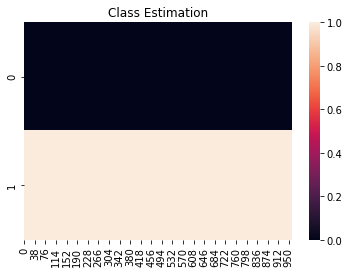

In [655]:
sns.heatmap(pos_pob);
plt.title('Class Estimation');

<b> Result Analysis: </b> While trying to capture the temporal structure in our data, In this method we are greedily making a decision on the underlying state of each sample based on the state of the previous sample. While we might get lucky at times with this approach, this method is unreliable to generate the best possible set of sequences everytime. As in this case, the result is unsatisfactory as our model classified all the samples into a single class. Since the first sample was misclassified, subsequent samples were also misclassified.

Let's use the viterbi algorithm for our sequential model as it uses dynamic programming to render the best possible set of state sequences, i.e., the set of states that have the highest joint probability.

<b>Step 10:</b> Let's initialize a posterior probabiliy matrix to store the likelihood of a data sample belonging to each class.

In [656]:
v_pos_pob=np.zeros((pdf.shape[0],pdf.shape[1]))

In [657]:
v_pos_pob[:,0]=pdf[:,0]

<b>Step 11:</b> Let's initialize a matrix B to store the best previous state sequences for any time frame. We use this matrix to back track and get the final result.

In [658]:
B=np.zeros((pdf.shape[0],pdf.shape[1]))

<b>Step 12:</b> Calculate the posterior probability using the Tranisition and posterior probability matrix generated before. Store the best possible state sequeces in matrix B.

In [659]:
for i in range(1,v_pos_pob.shape[1]):
    for j in range(v_pos_pob.shape[0]):
        b=np.argmax(T[:,j]*v_pos_pob[:,i-1])
        B[j,i]=b
        v_pos_pob[j,i]=T[b,j]*v_pos_pob[b,i-1]*pdf[j,i]


<b>Step 13:</b> Normalize the posterior probability matrix as before.

In [660]:
#Normalize posterior probability
for i in range(v_pos_pob.shape[1]):
    v_pos_pob[:,i]/=sum(v_pos_pob[:,i])

<b>Step 14:</b> Use Matrix B to get the final result- Best set of states that represents the data frames.

In [661]:
result=[0]*B.shape[1]
result[-1]=np.argmax(v_pos_pob[:,-1])
for i in range(len(result)-2,-1,-1):
    b=int(result[i+1])
    result[i]=B[b,i]
    

In [662]:
final_result=np.zeros(v_pos_pob.shape).T


In [663]:
for i in range(len(result)):
    if result[i]:
        final_result[i,1]=1
    else:
        final_result[i,0]=1
    

In [664]:
final_result=final_result.T

<b>Step 15:</b> Plot the final result using a heatmap as before.

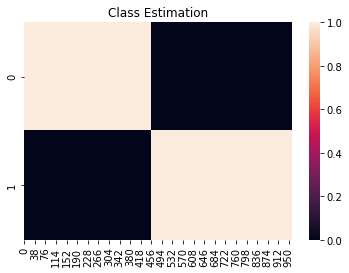

In [665]:
sns.heatmap(final_result);
plt.title('Class Estimation');

The plot correctly represents the transition in states between data samples. There's a transition near the 456 sample, and there are no wrong claps.

# Part 2: Multidimensional scaling

<b>Step 1:</b> Load the data matrix.

In [666]:
data=loadmat('MDS_pdist.mat')['L']

<b>Step 2:</b> Plot the data matrix that represents the pairwise distance in between data points.

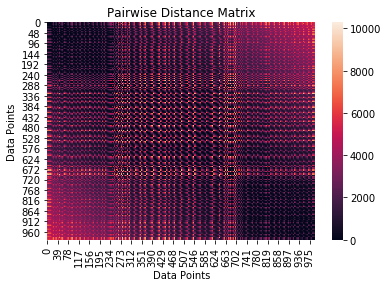

In [667]:
sns.heatmap(data);
plt.title('Pairwise Distance Matrix');
plt.xlabel('Data Points');
plt.ylabel('Data Points');

<b>Step 3:</b> Transform the pairwise distance matrix into an affinity matrix.

i) Average along the rows and subtract the mean column vector from the pairwise distance matrix.

In [668]:
M_bar=np.mean(data,axis=1) #Mean row vector

In [669]:
data-=M_bar

ii) Average along the columns and subtract the mean row vector from the remaining data matrix.

In [670]:
M_column=np.mean(data,axis=0)

In [671]:
data-=M_column #Affinity Matrix

<b>Step 4:</b> Apply Eigen decomposition on the Affinity Matrix

In [672]:
U,V,_=np.linalg.svd(data)

In [673]:
V=np.diag(V)

<b>Step 5:</b> Recover the data points from the most significant eigen vectors.

In [674]:
d_points=U.dot((V)**(0.5))

In [675]:
d_points.shape

(996, 996)

In [676]:
d_points=d_points[:,:2]

In [677]:
d_points

array([[-45.49290162,  65.78762591],
       [-42.58969205,  63.40451812],
       [-38.29255335,  62.8895773 ],
       ...,
       [-50.35960924, -44.87634602],
       [-44.50911804, -46.30395993],
       [-40.97846627, -48.40824593]])

<b>Step 6:</b> Plot the recovered data points.

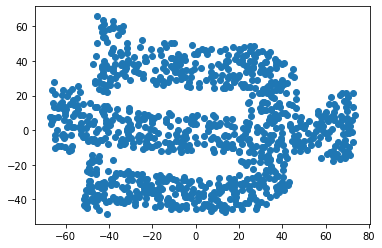

In [678]:
plt.scatter(d_points[:,0],d_points[:,1]);

The recovered data point represent a rotated and shifted version of the IU Trident.

<b>Step 7:</b> Let's the rotate the data points for proper representation.

In [679]:
rotation_matrix=np.array([[0,1],[-1,0]])
d_points=(rotation_matrix.dot(d_points.T)).T

In [680]:
d_points.shape

(996, 2)

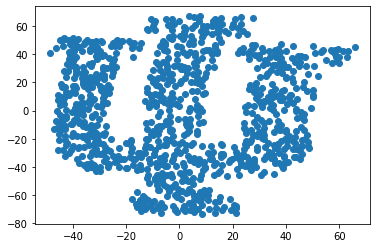

In [681]:
plt.scatter(d_points[:,0],d_points[:,1]);

# Part 3: Kernel PCA and Perceptron Classification

# Kernel PCA

<b>Step 1:</b> Load the data matrix and visualize it.

In [6]:
data=loadmat('concentric.mat')['X']

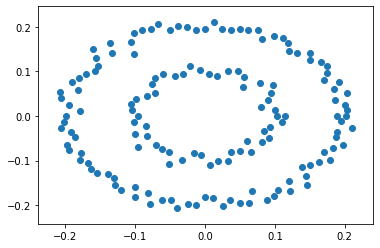

In [10]:
%matplotlib inline
from matplotlib import pyplot
plt.scatter(data[0],data[1]);

In [11]:
no_samples=data.shape[1]

<b>Step 2:</b> Calculate pariwise distances between data points.

In [14]:
import numpy as np
pair_dist=np.zeros((no_samples,no_samples))

In [15]:
for i in range(no_samples):
    for j in range(no_samples):
        pair_dist[i,j]=np.linalg.norm(data[:,i]-data[:,j])

<b>Step 3:</b> Let's visualize the pairwise distance matrix using a heatmap.

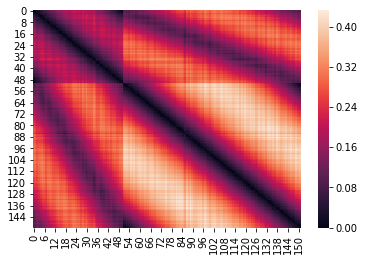

In [16]:
sns.heatmap(pair_dist);

<b>Step 4:</b> Let's construct a RBF kernel using the pariwise distance matrix.

In [17]:
#Construct RBF Kernel K

sigma=1
K=np.exp(-(pair_dist*pair_dist)/(sigma)**2)

<b>Step 5:</b> Let's visualize the RBF kernel using a heatmap.

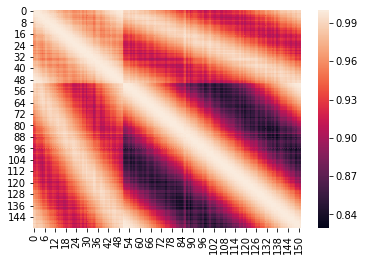

In [18]:
sns.heatmap(K);

In the heatmap, we can clearly see that the distances between closer data points is emphasized.

<b>Step 6:</b> Apply Eigendecomposition on the RBF Kernel matrix, and choose the most significant eigen vectors.

In [19]:
eig_val,eig_vect=np.linalg.eig(pair_dist)

In [20]:
alpha=eig_vect[:,:3]


In [21]:
alpha.shape

(152, 3)

<b>Step 7:</b> Compute the coordinates in the transformed space. 

In [22]:
y=alpha.T.dot(K)

In [23]:
y.shape

(3, 152)

<b>Step 8:</b> Let's visualize the data points in the transformed space.

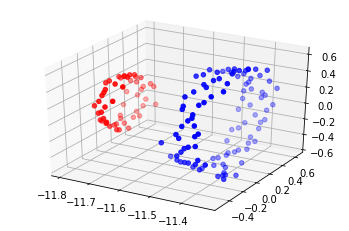

In [24]:
%matplotlib inline
from mpl_toolkits import mplot3d


fig = plt.figure()
ax = plt.axes(projection="3d")

ax.scatter3D(y[0][:51], y[1][:51], y[2][:51], c='r');

ax.scatter3D(y[0][51:], y[1][51:], y[2][51:], c='b');

plt.show()


In the above plot we can clearly see that the data points, orginally non-linear, are linearly separable in the transformed space.

# Perceptron Classification

<b>Step 1:</b> The transformed data has three input features, and the first 51 samples belong to one class, and the rest 101 samples belong to other class. To perform perceptron classification on this dataset let's add labels to the data points. 

In [25]:
labels=[0]*51+[1]*101

<b>Step 2:</b> Let's normalize the dataset.

In [26]:
y=y.T
for i in range(y.shape[1]):
   
    y[:,i]=(y[:,i]-np.mean(y[:,i]))/(np.max(y[:,i])-np.min(y[:,i]))



In [27]:
y=y.T

<b>Step 3:</b> Shuffle and split the dataset into training and test datasets, where training data consists of 80% of the samples.

In [28]:
trans_data=np.concatenate((y.T,np.array(labels).reshape(-1,1)),axis=1)

In [29]:
np.random.shuffle(trans_data)

In [30]:
trans_data=trans_data.T

In [31]:
#Test and Train split

train_set=trans_data[:,:int(0.8*trans_data.shape[1])]
test_set=trans_data[:,int(0.8*trans_data.shape[1]):]

In [32]:
train_features=train_set[:3,:]
train_labels=train_set[3,:]

In [33]:
test_features=test_set[:3,:]
test_labels=test_set[3,:]

In [34]:
train_features.shape

(3, 121)

In [36]:
train_labels

array([1., 0., 0., 1., 0., 1., 1., 1., 0., 1., 1., 0., 0., 1., 1., 1., 1.,
       1., 1., 0., 1., 0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 0., 1.,
       0., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1.,
       0., 0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 0., 1., 1., 1., 1.,
       1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1.,
       0., 1., 0., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 1.,
       1., 1.])

<b>Step 4:</b> Let's define our perceptron model. Let's use sigmoid activation function for non-linearity.

In [705]:
class Perceptron:
    def __init__(self,n_features):
        self.weights=np.random.randn(n_features+1,1)
    
    def sigmoid(self,X):
        
        """Computes the result of Logistic/Sigmoid activation function on X"""
        
        return 1/(1+np.exp(-X))
    
    def d_sigmoid(self,X):
        
        """Compute Derivative of Sigmoid function on X"""
        
        return self.sigmoid(X)*(1-self.sigmoid(X))
    
    def train(self,X_train,Y_train,epochs,learning_rate):
        
        """
        Processes input data, and trains the perceptron 
        """
        
        padding=[1]*X_train.shape[1]
        padding=np.array(padding).reshape(-1,1)
        X_train=(np.concatenate((X_train.T,padding),axis=1)).T
        
        
        
        error=[]
        for i in range(1,epochs+1):
            predictions=self.forward_prop(X_train)
            error.append(self.mse(predictions,Y_train))
            self.back_prop(predictions,X_train,Y_train,learning_rate)
            
        plt.plot(error)
        plt.title('Convergence Graph')
        plt.xlabel('Iterations')
        plt.ylabel('Error')
    def forward_prop(self,X_train):
        return self.sigmoid((self.weights.T).dot(X_train))
    
    def back_prop(self,predictions,X_train,Y_train,learning_rate):
        
        """Gradient Descent for perceptron"""
        
        gradient=X_train.dot(((Y_train-predictions)*(self.d_sigmoid(self.weights.T.dot(X_train)))).T)
        self.weights+=((1/(2*len(Y_train)))*learning_rate)*(gradient)
    
    def mse(self,predictions,Y_train):
        
        """Computes Mean Square Error"""
        
        return 1/2*((Y_train-predictions).dot((Y_train-predictions).T))[0]
    
    def predict(self,X_test,Y_test):
        
        """Evaluates the performance of the model on Unseen/Test Data"""
        
        padding=[1]*X_test.shape[1]
        padding=np.array(padding).reshape(-1,1)
        X_test=(np.concatenate((X_test.T,padding),axis=1)).T
        predictions=self.forward_prop(X_test)
        predictions=np.array([1 if i>=0.5 else 0 for i in predictions[0]])
        return (sum(predictions==Y_test)/len(Y_test))*100
        

<b>Step 5:</b> Initialize and train the perceptron model.

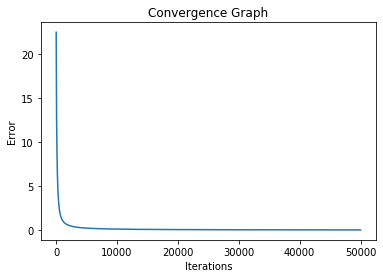

In [706]:
model=Perceptron(train_features.shape[0])

model.train(train_features,train_labels,50000,0.8)

<b>Step 6:</b> Evaluate the performance of the model on unseen data.

In [707]:
print('Test Accuracy',model.predict(test_features,test_labels))

Test Accuracy 100.0


<b>Step 6:</b> Let's visualize the decision boundary learnt by the perceptron model.

In [708]:
r1=np.linspace(-1,1)
r2=np.linspace(-1,1)

In [709]:
model.weights.shape

(4, 1)

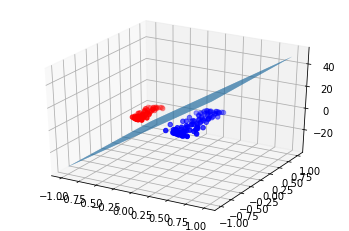

In [710]:
%matplotlib inline
from mpl_toolkits import mplot3d


fig = plt.figure()
ax = plt.axes(projection="3d")

ax.scatter3D(y[0][:51], y[1][:51], y[2][:51], c='r');

ax.scatter3D(y[0][51:], y[1][51:], y[2][51:], c='b');
r1 = np.linspace(-1,1,10)
r1 = np.linspace(-1,1,10)
X,Y = np.meshgrid(r1,r2)
Z = (-model.weights[3,0] - model.weights[0,0]*X - model.weights[1,0]*Y) / model.weights[2,0]
ax.plot_surface(X, Y, Z)
plt.show()


In the above plot we can see that the decision boundary learnt by our model perfectly seperates both the classes.

# Part 4

<b>Step 1:</b> Load and visualize the data.

In [711]:
data=loadmat('concentric.mat')['X']

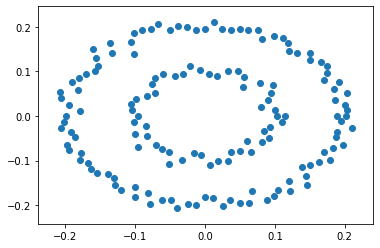

In [712]:
plt.scatter(data[0,:],data[1,:]);


<b>Step 2:</b> Add labels to the input data

In [713]:
labels=np.array([0]*51+[1]*(152-51))

In [714]:
labels=labels.reshape((152,1))

<b>Step 3:</b> Normalize and shuffle the input data.

In [715]:
data=data.T
for i in range(data.shape[1]):
   
    data[:,i]=(data[:,i]-np.mean(data[:,i]))/(np.max(data[:,i])-np.min(data[:,i]))

data=data.T

In [716]:
data=np.concatenate((data.T,labels),axis=1)

In [717]:
np.random.shuffle(data)

In [718]:
data=data.T

<b>Step 4:</b> Divide the data into training and test datasets where the training set contains 80% of the data.

In [719]:
#Test and Train split

train_set=data[:,:int(0.8*data.shape[1])]
test_set=data[:,int(0.8*data.shape[1]):]


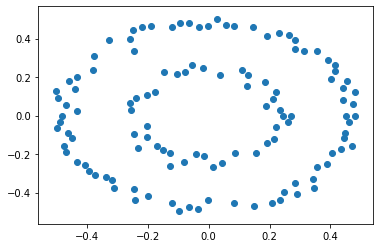

In [720]:
plt.scatter(train_set[0,:],train_set[1,:]);

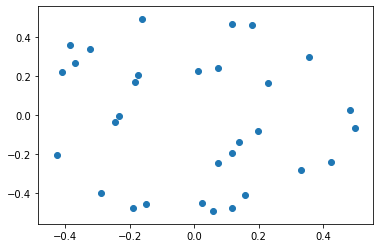

In [721]:
plt.scatter(test_set[0,:],test_set[1,:]);

In [722]:
train_features=train_set[:2,:]
train_labels=train_set[2,:]

In [723]:
test_features=test_set[:2,:]
test_labels=test_set[2,:]

<b>Step 5:</b> Define a shallow neural network with 3 units in the hidden layer.

In [724]:
class NN:
    def __init__(self,h_units):
        self.W_1=np.random.randn(h_units,2)*0.01 #Randomly intialized layer 1 weight matrix with dims 3*2
        self.b_1=np.zeros((h_units,1)) #Bias of the hidden units in layer 1
        self.W_2=np.random.randn(1,h_units)*0.01 #Randomly intialized layer 2 weight matrix with dims 1*3
        self.b_2=np.zeros((1,1)) #Bias of the hidden unit in layer 2/output layer
        
    def sigmoid(self,X):
        
        """Computes the result of sigmoid function on X"""
        
        return 1/(1+np.exp(-X))
    def d_sigmoid(self,X):
        
        """Computes the derivative of sigmoid funcion on X"""
        
        return self.sigmoid(X)*(1-self.sigmoid(X))
    
    def fit(self,X,y,alpha,batch_size,iterations):
        
        """Trains the model using gradient descent"""
        
        loss=[]
        acc=[]
        for i in range(1,iterations+1):
            
            
            data=np.concatenate((X.T,y.reshape(-1,1)),axis=1)
            np.random.shuffle(data)
            data=data.T
            X=data[:2,:]
            y=data[2,:]
            activations=self.foward_prop(X)
            predictions=activations[3]
            loss.append(self.loss_function(predictions,y))
            acc.append(self.accuracy(predictions,y))
            #print('Epoch',i,'Loss:',loss[i-1],'Accuracy:',acc[i-1])
            self.back_prop(activations,X,y,alpha)
        
        return loss,acc
        
    def foward_prop(self,X):
        
        """Computes the output of the model"""
        
        Z_1=self.W_1.dot(X)+self.b_1
        A_1=self.sigmoid(Z_1)
        Z_2=self.W_2.dot(A_1)+self.b_2
        A_2=self.sigmoid(Z_2)
        
        return Z_1,A_1,Z_2,A_2
    
    def loss_function(self,p,y):
        
        """Computes the cost/error associated with each prediction of the model"""
        
        p=p.T
        return np.sum(-1*(y.dot(np.log(p))+(1-y).dot(np.log(1-p))))
    
    def back_prop(self,l_out,X,y,alpha):
        
        """Backpropagation of error and Gradient Descent"""
        
        Z_1,A_1,Z_2,A_2=l_out[0],l_out[1],l_out[2],l_out[3]
        m=len(y)
        
        dZ_2=A_2-y
        dW_2=(1/m)*(dZ_2.dot(A_1.T))
        db_2=(1/m)*(np.sum(dZ_2,axis=1,keepdims=True))
        
        dZ_1=(self.W_2.T).dot(dZ_2)*self.d_sigmoid(Z_1)
        dW_1=(1/m)*dZ_1.dot(X.T)
        db_1=(1/m)*np.sum(dZ_1,axis=1,keepdims=True)
        
        #Update weights
        
        self.W_1-=alpha*dW_1
        self.W_2-=alpha*dW_2
        
        self.b_1-=alpha*db_1
        self.b_2-=alpha*db_2
        
        
    def accuracy(self,p,y):
        
        """Computes the accuracy of predictions"""
        
        p=np.array([1 if i>=0.5 else 0 for i in p.T])
        return (sum(p==y)/len(y))*100
        
        
        
    def evalute(self,X_test,y_test):
        
        """Evaluates the performance of the model on unseen/test data"""
        
        predictions=self.foward_prop(X_test)[3]
        print('Test accuracy:',self.accuracy(predictions,y_test))
        
        
    
    
        
        

<b>Step 6:</b> Initialize and train the model. 

In [725]:
model=NN(3)

In [726]:
loss,acc=model.fit(train_features,train_labels,0.5,len(train_labels),50000)

<b>Step 7:</b> Plot the convergence graph

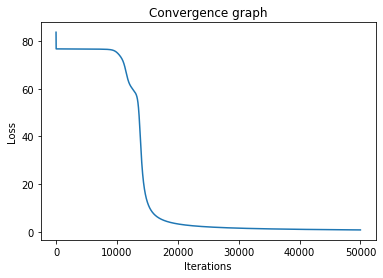

In [727]:
plt.plot(loss);
plt.title('Convergence graph');
plt.xlabel('Iterations');
plt.ylabel('Loss');

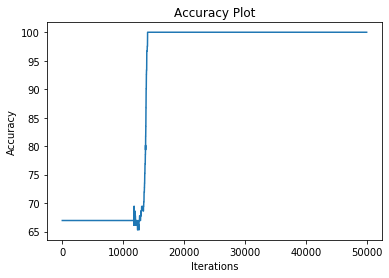

In [728]:
plt.plot(acc);
plt.title('Accuracy Plot');
plt.xlabel('Iterations');
plt.ylabel('Accuracy');

<b>Step 8:</b> Evaluate the performance of the model on unseen data.

In [729]:
model.evalute(test_features,test_labels)

Test accuracy: 100.0
